# Predição de Dengue - Modelos de Classificaao KNN e SVM
## Autor - Francisco Flávio Cardoso Gomes
## Fonte de dados 
### Dados Metereológicos - Inmet - Instituto Nacional de Metereologia
### Dados de Infectados por dengue - SinanWeb - Sistema de Notificação de Agravos e Notificação


### Este modelo avalia os modelos de KNN(k-Nearest Neighbors e SVM(Support vector machine) para previsão de picos de casos de Dengue em Fortaleza

## - Periodicidade da Série Temporal - Diário

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import  pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')
import time as time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler


### Lê Dados Metereológicos

In [2]:
file='./Dados/Fortaleza/Fortaleza_Inmet_Diario_Corrigido.csv'
data = pd.read_csv(file,sep=',')
data = data.rename(columns={'Evaporacao Piche': 'Evaporacao', 'Temp Comp Media': 'TempMedia','Umidade Relativa Media':'Umidade','Velocidade do Vento Media':'VelVento'})
data


,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao,TempMedia,Umidade,VelVento,Semana,Ano
0,82397,01/01/2007,0,0.0,30.600000,27.4,8.300000,7.300000,28.000000,74.00000,3.971840,1,2007
1,82397,02/01/2007,0,0.0,32.000000,27.1,11.300000,6.900000,28.820000,69.50000,3.966667,1,2007
2,82397,03/01/2007,0,0.5,29.500000,25.9,1.300000,8.200000,27.240000,81.75000,2.433333,1,2007
3,82397,04/01/2007,0,7.9,31.300000,25.9,11.200000,3.100000,27.800000,71.50000,3.166667,1,2007
4,82397,05/01/2007,0,2.7,28.700000,24.0,3.000000,5.900000,26.520000,83.75000,3.766667,1,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4921,82397,22/06/2019,1200,0.0,31.362319,23.3,7.713613,4.242638,27.176183,77.73468,2.808384,25,2019
4922,82397,23/06/2019,1200,0.0,31.362319,23.3,7.713613,4.242638,27.176183,77.73468,2.808384,25,2019
4923,82397,24/06/2019,0,0.0,30.500000,23.7,8.900000,4.242638,26.480000,77.00000,1.286100,26,2019
4924,82397,25/06/2019,0,0.0,30.600000,23.3,8.800000,4.242638,26.540000,80.00000,2.057760,26,2019


### Lê dados de Infectados por Dengue

In [3]:

file2='./Dados/Fortaleza/Fortaleza_Infectados_Diarios.csv'
data2 = pd.read_csv(file2,sep=',')
data2 = data2.rename(columns={'Data_Notificacao':'Data','Infectados_Dengue':'Infectados'})
data2


,Data,Infectados,Semana,Ano
0,01/01/2007,6,1,2007
1,02/01/2007,10,1,2007
2,03/01/2007,26,1,2007
3,04/01/2007,20,1,2007
4,05/01/2007,22,1,2007
...,...,...,...,...
4921,22/06/2020,4,26,2020
4922,23/06/2020,4,26,2020
4923,24/06/2020,0,26,2020
4924,25/06/2020,0,26,2020


### Verificar dados faltando de Metereologia### Verificar dados faltando no dataset Inmet

In [4]:
tot_nulos=data.isnull().sum()
tot_nulos

Estacao         0
Data            0
Hora            0
Precipitacao    0
TempMaxima      0
TempMinima      0
Insolacao       0
Evaporacao      0
TempMedia       0
Umidade         0
VelVento        0
Semana          0
Ano             0
dtype: int64

### Verifica Nulos da variável dependente - N. de infectados.

In [5]:
tot_nulos=data2.isnull().sum()
tot_nulos

Data          0
Infectados    0
Semana        0
Ano           0
dtype: int64

# Plota dados de Infectados ao longo do tempo

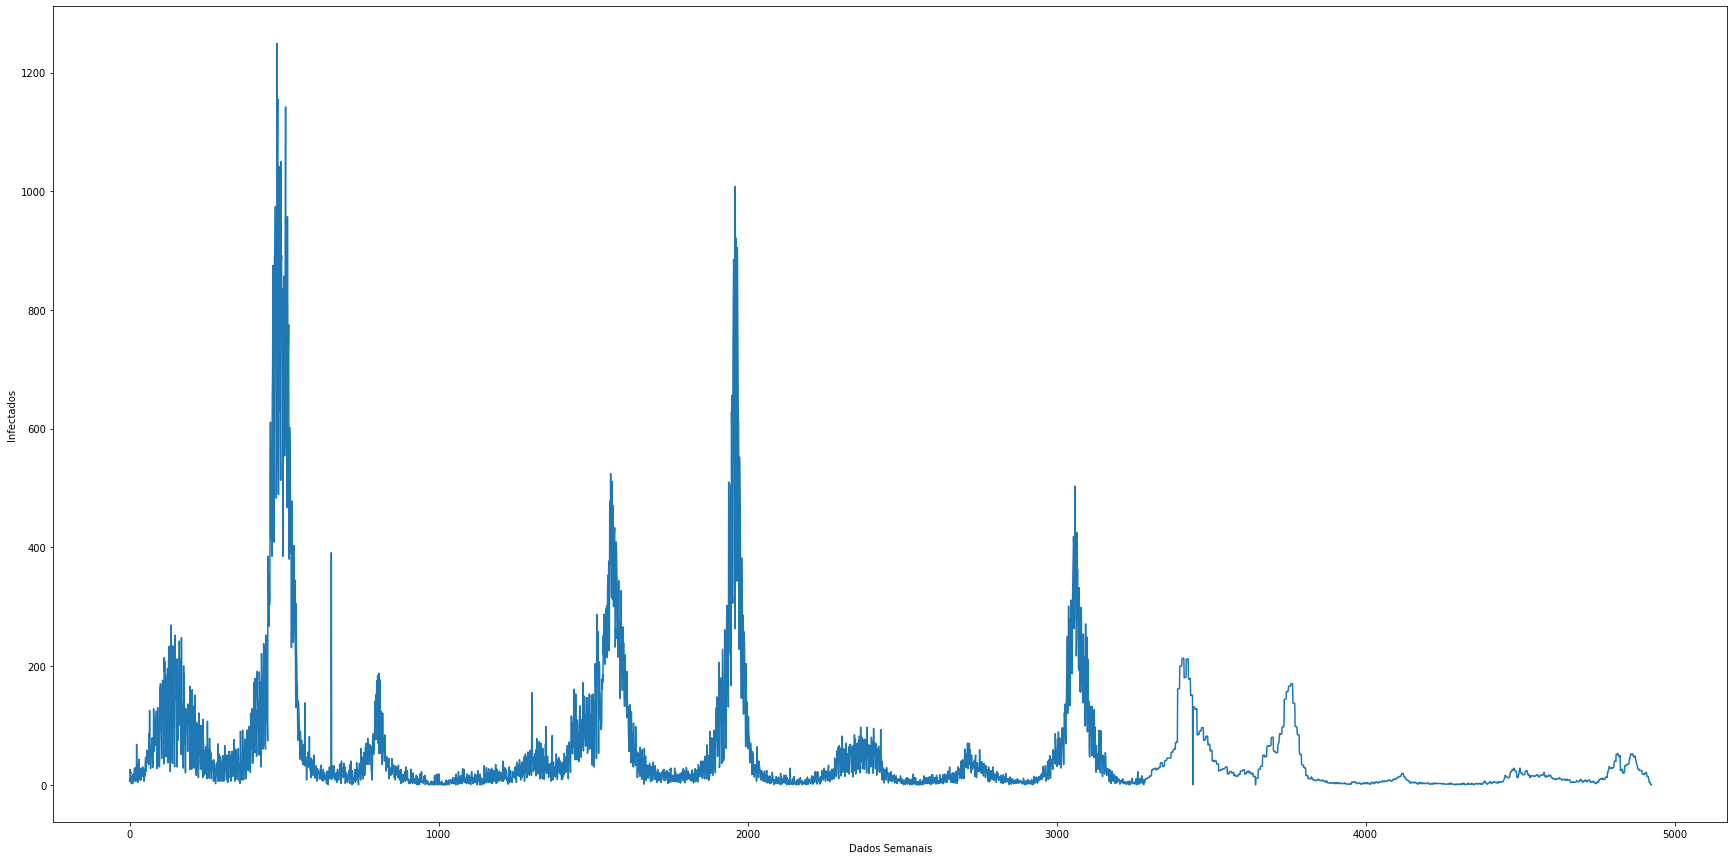

In [6]:

plt.figure(figsize=(30,15))
plt.xlabel('Dados Semanais')
plt.ylabel('Infectados')
plt.plot(data2['Infectados'])
plt.show()

### Seleciona dados com Picos de Dengue

In [7]:
data2=data2.iloc[0:4000]
data=data.iloc[0:4000]

data.loc[:,'Ano']

0       2007
1       2007
2       2007
3       2007
4       2007
        ... 
3995    2017
3996    2017
3997    2017
3998    2017
3999    2017
Name: Ano, Length: 4000, dtype: int64

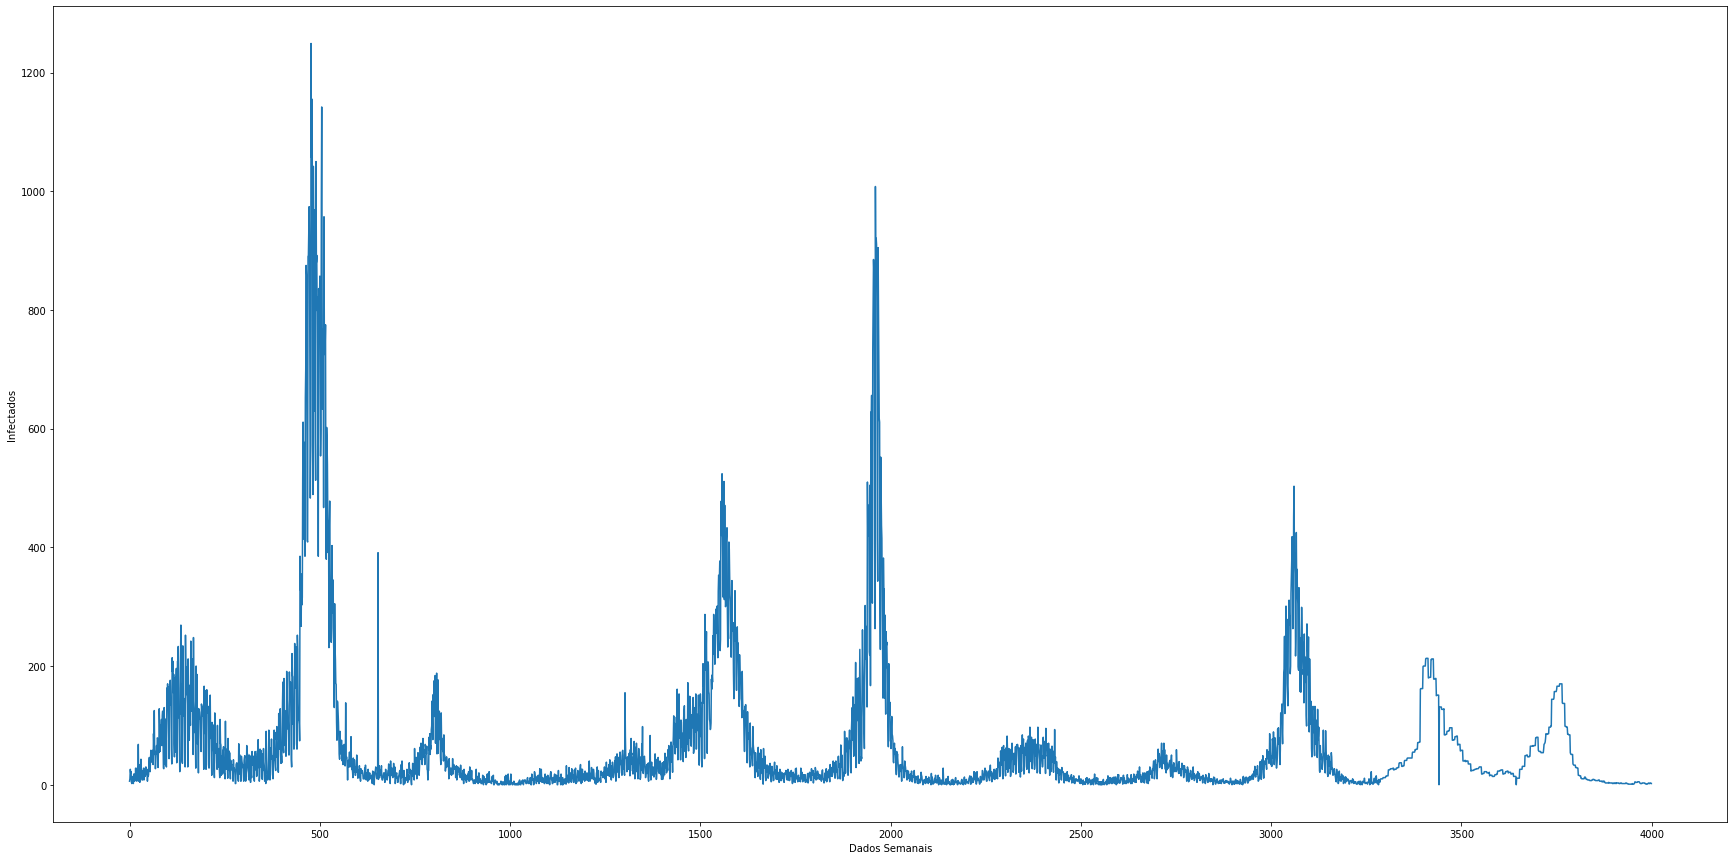

In [8]:
# Analisar dados de "Infectados" ao longo do tempo
plt.figure(figsize=(30,15))
plt.xlabel('Dados Semanais')
plt.ylabel('Infectados')
plt.plot(data2['Infectados'])
plt.show()

## Divide os dados em Dados de Treino e Teste

In [9]:
X_train=data.iloc[:2500]
X_test=data.iloc[2500:]
y_train = data2.iloc[:2500]
submission = data2.iloc[2500:]

X_train,X_test

(      Estacao        Data  Hora  Precipitacao  TempMaxima  TempMinima  \
 0       82397  01/01/2007     0           0.0        30.6        27.4   
 1       82397  02/01/2007     0           0.0        32.0        27.1   
 2       82397  03/01/2007     0           0.5        29.5        25.9   
 3       82397  04/01/2007     0           7.9        31.3        25.9   
 4       82397  05/01/2007     0           2.7        28.7        24.0   
 ...       ...         ...   ...           ...         ...         ...   
 2495    82397  31/10/2013     0           0.0        32.0        25.5   
 2496    82397  01/11/2013     0           0.0        31.9        25.3   
 2497    82397  02/11/2013     0           0.1        32.6        25.3   
 2498    82397  03/11/2013     0           0.5        32.6        24.9   
 2499    82397  04/11/2013     0           2.6        31.8        24.7   
 
       Insolacao  Evaporacao  TempMedia  Umidade  VelVento  Semana   Ano  
 0           8.3         7.3      2

### Normalizador estatístico, onde o resultado da normalização garante média zero e variância/desvio parão unitária.

In [10]:
normalizador = StandardScaler()

X_train.iloc[:,2:] = normalizador.fit_transform(X_train.iloc[:,2:])
X_test.iloc[:,2:] = normalizador.transform(X_test.iloc[:,2:])
X_train,X_test,

(      Estacao        Data  Hora  Precipitacao  TempMaxima  TempMinima  \
 0       82397  01/01/2007   0.0     -0.358242   -0.614816    2.989972   
 1       82397  02/01/2007   0.0     -0.358242    0.632565    2.737566   
 2       82397  03/01/2007   0.0     -0.316350   -1.594901    1.727942   
 3       82397  04/01/2007   0.0      0.303642    0.008874    1.727942   
 4       82397  05/01/2007   0.0     -0.132028   -2.307691    0.129370   
 ...       ...         ...   ...           ...         ...         ...   
 2495    82397  31/10/2013   0.0     -0.358242    0.632565    1.391400   
 2496    82397  01/11/2013   0.0     -0.358242    0.543466    1.223130   
 2497    82397  02/11/2013   0.0     -0.349863    1.167157    1.223130   
 2498    82397  03/11/2013   0.0     -0.316350    1.167157    0.886588   
 2499    82397  04/11/2013   0.0     -0.140406    0.454367    0.718317   
 
       Insolacao  Evaporacao  TempMedia   Umidade  VelVento    Semana       Ano  
 0      0.138888    1.568422

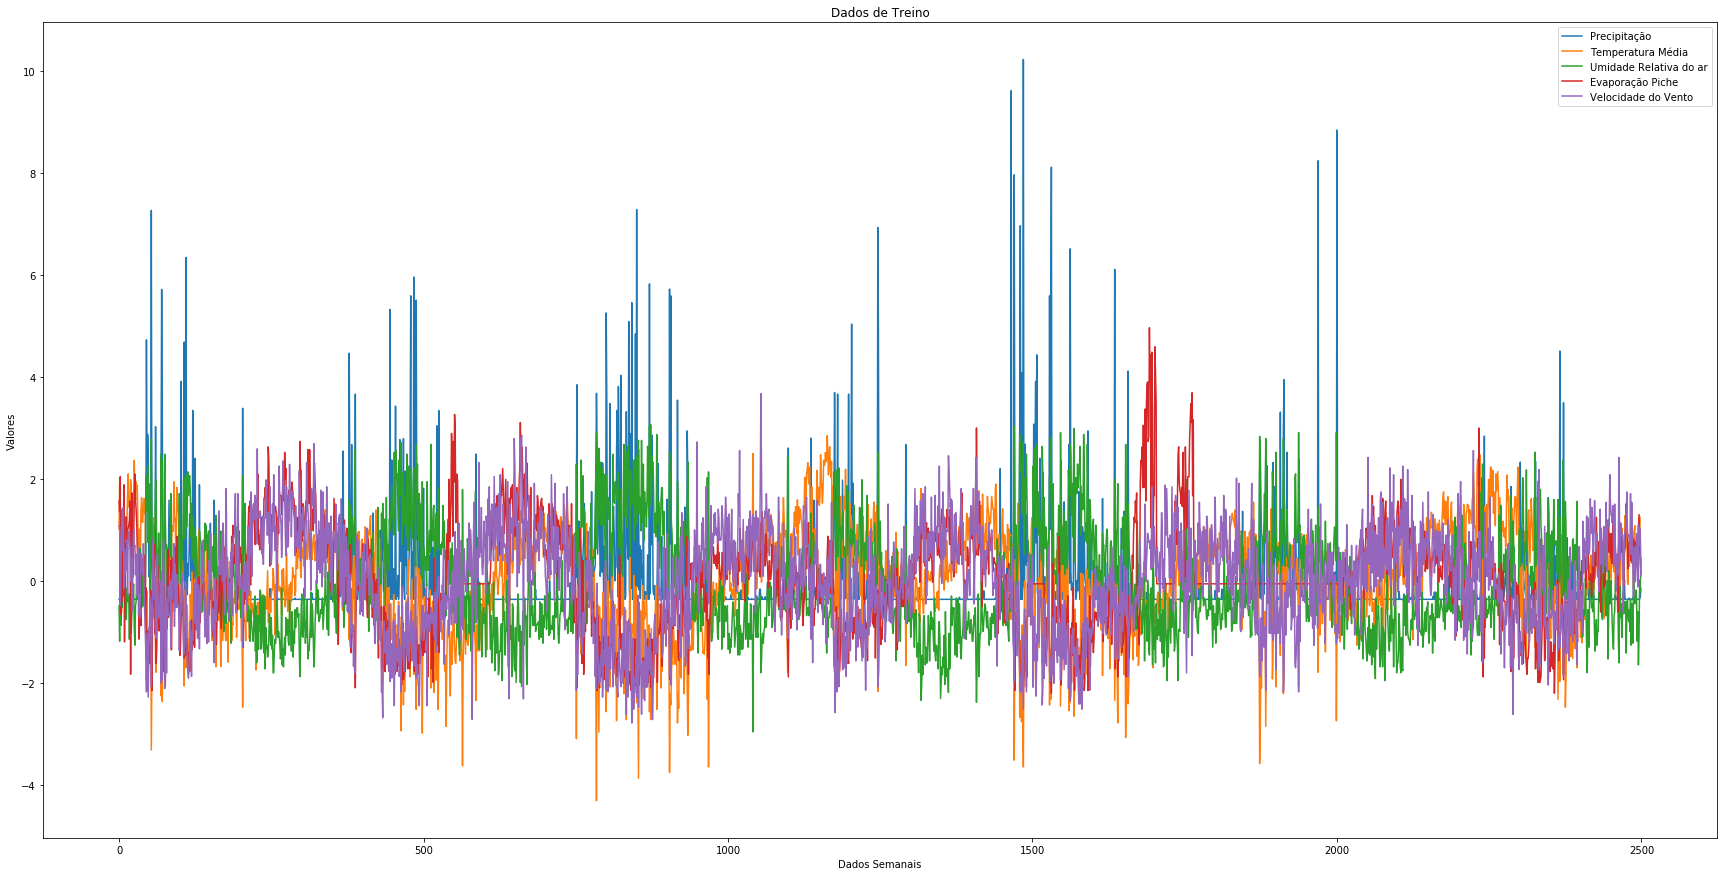

In [11]:
## Dados Metereologicos de Treino
plt.figure(figsize=(30,15))
X_train.Precipitacao.plot(label="Precipitação")
X_train.TempMedia.plot( label="Temperatura Média")
X_train.Umidade.plot( label="Umidade Relativa do ar")
X_train.Evaporacao.plot( label="Evaporação Piche")
X_train.VelVento.plot( label="Velocidade do Vento")
plt.title("Dados de Treino")
plt.legend()
plt.xlabel('Dados Semanais')
plt.ylabel('Valores')

plt.show()

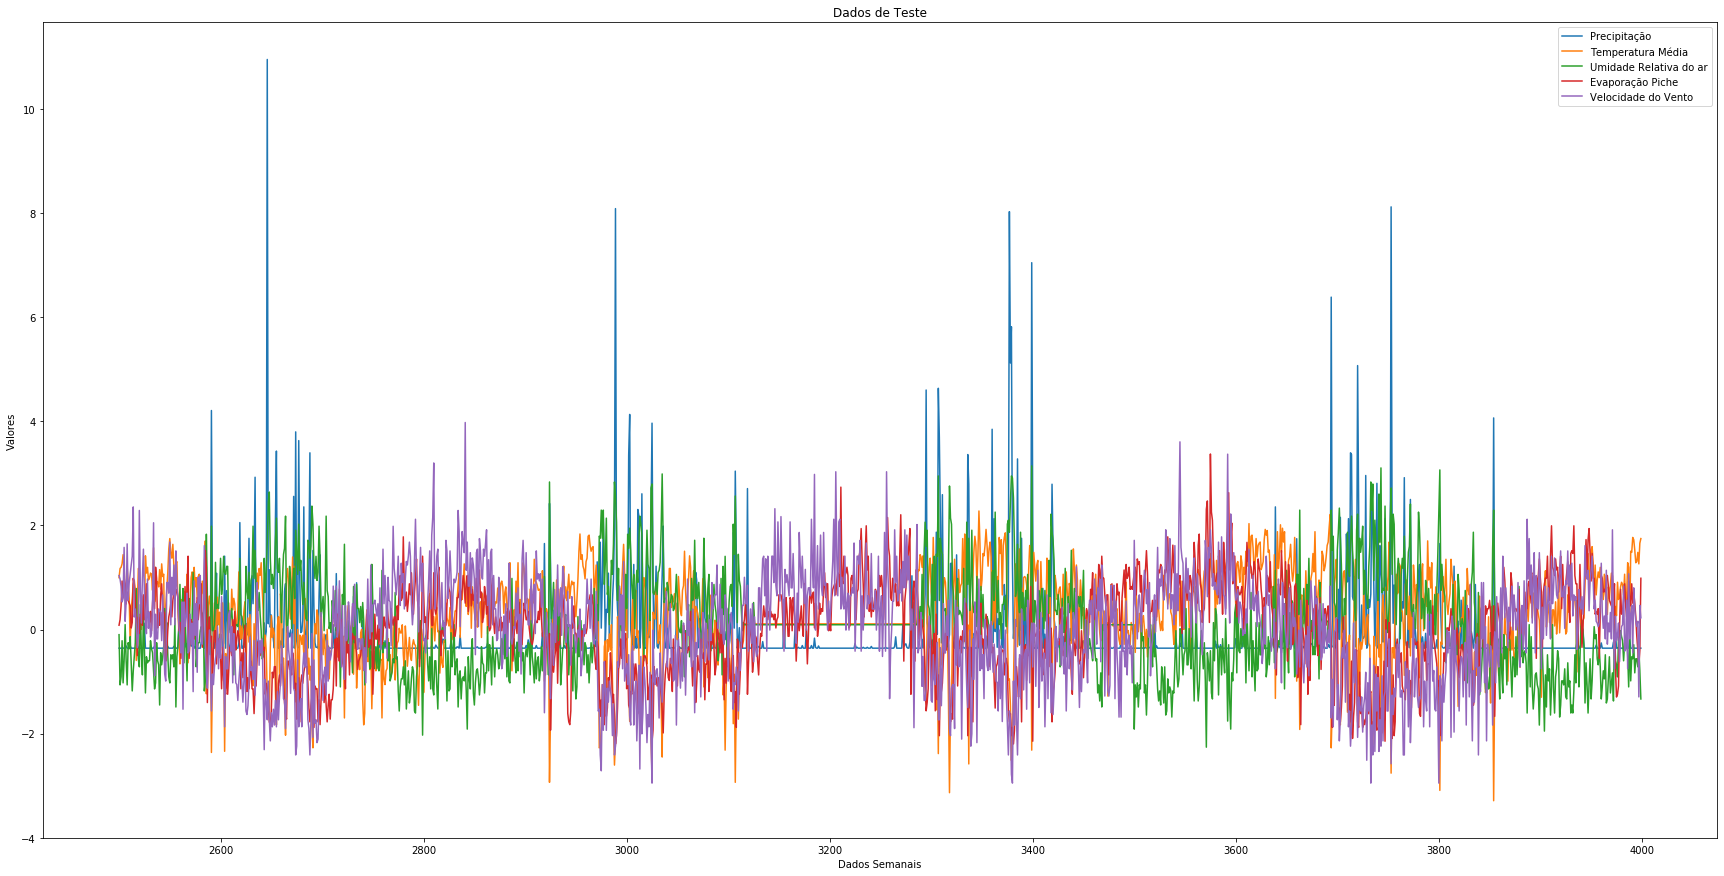

In [12]:
## Dados Metereologicos de Teste
plt.figure(figsize=(30,15))
X_test.Precipitacao.plot(label="Precipitação")
X_test.TempMedia.plot( label="Temperatura Média")
X_test.Umidade.plot( label="Umidade Relativa do ar")
X_test.Evaporacao.plot( label="Evaporação Piche")
X_test.VelVento.plot( label="Velocidade do Vento")
plt.title("Dados de Teste")
plt.legend()
plt.xlabel('Dados Semanais')
plt.ylabel('Valores')

plt.show()

Nossa variável de destino, "Infectados" é um número inteiro não negativo, o que significa que estamos procurando fazer algumas previsões de contagem. As técnicas de regressão padrão para esse tipo de previsão incluem:
Regressão de Poisson
Regressão binomial negativa.

Qual técnica terá melhor desempenho depende de muitas coisas, mas a escolha entre a regressão de Poisson e a regressão binomial negativa é bastante direta.

A regressão de Poisson se ajusta de acordo com a suposição de que a média e a variância da distribuição da população são iguais. Quando não são, especificamente quando a variação é muito maior que a média, a abordagem binomial negativa é melhor.

A regressão binomial negativa simplesmente levanta a suposição de que a média e variância da população são iguais, permitindo uma classe maior de modelos possíveis. De fato, dessa perspectiva, a distribuição de Poisson é apenas um caso especial da distribuição binomial negativa.

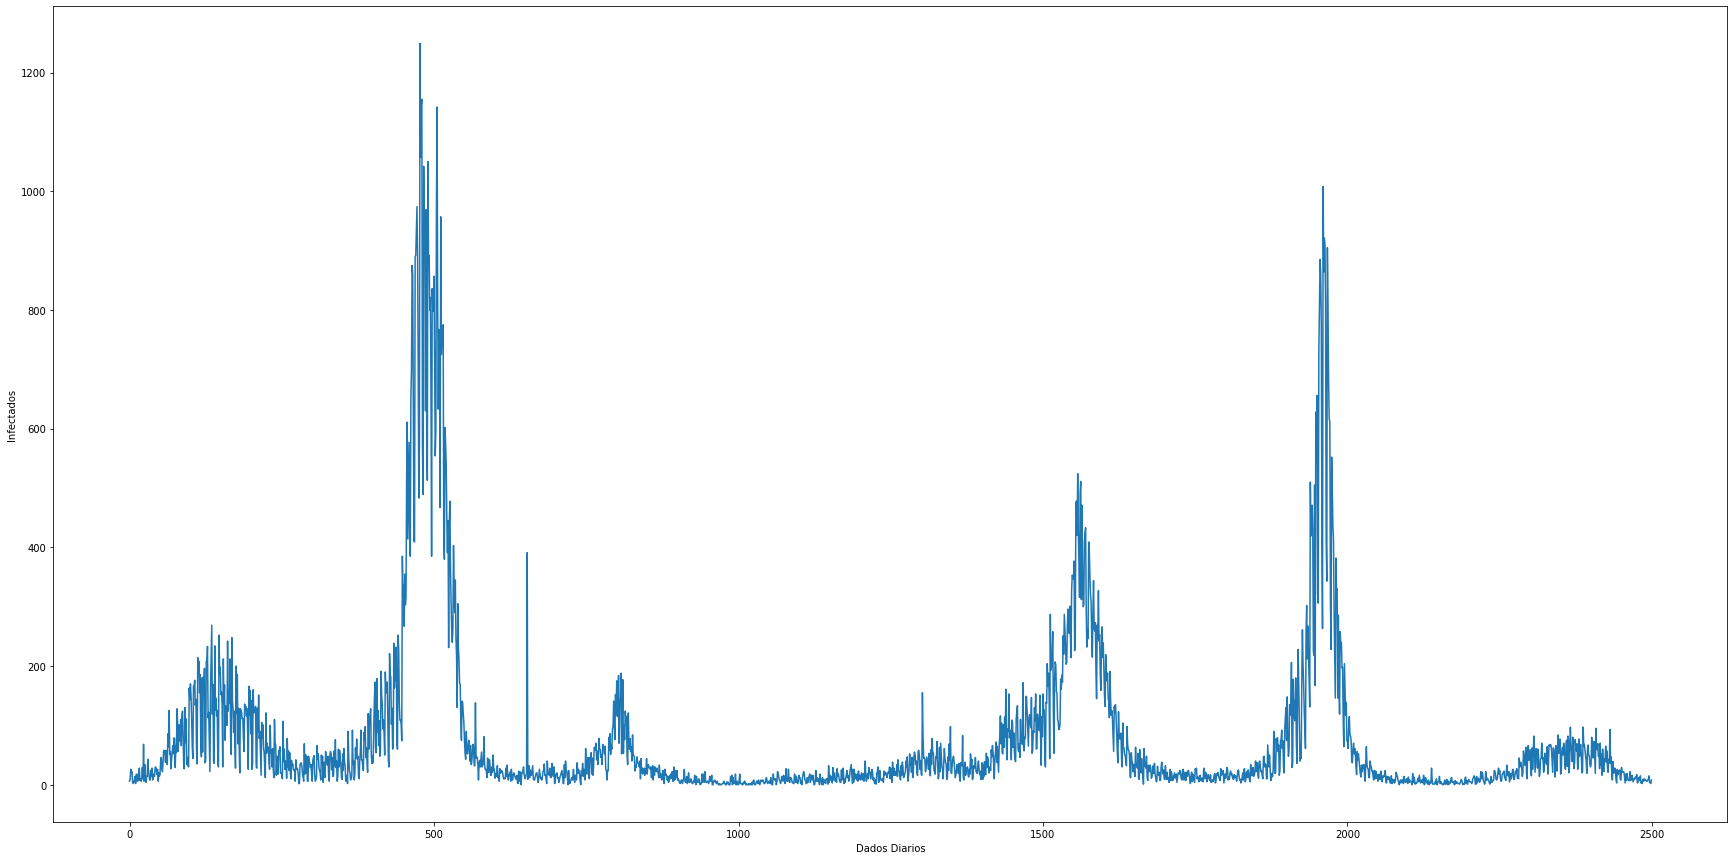

In [13]:
# Dados de "Infectados" de treino
plt.figure(figsize=(30,15))
plt.xlabel('Dados Diarios')
plt.ylabel('Infectados')
plt.plot(y_train['Infectados'])
plt.show()

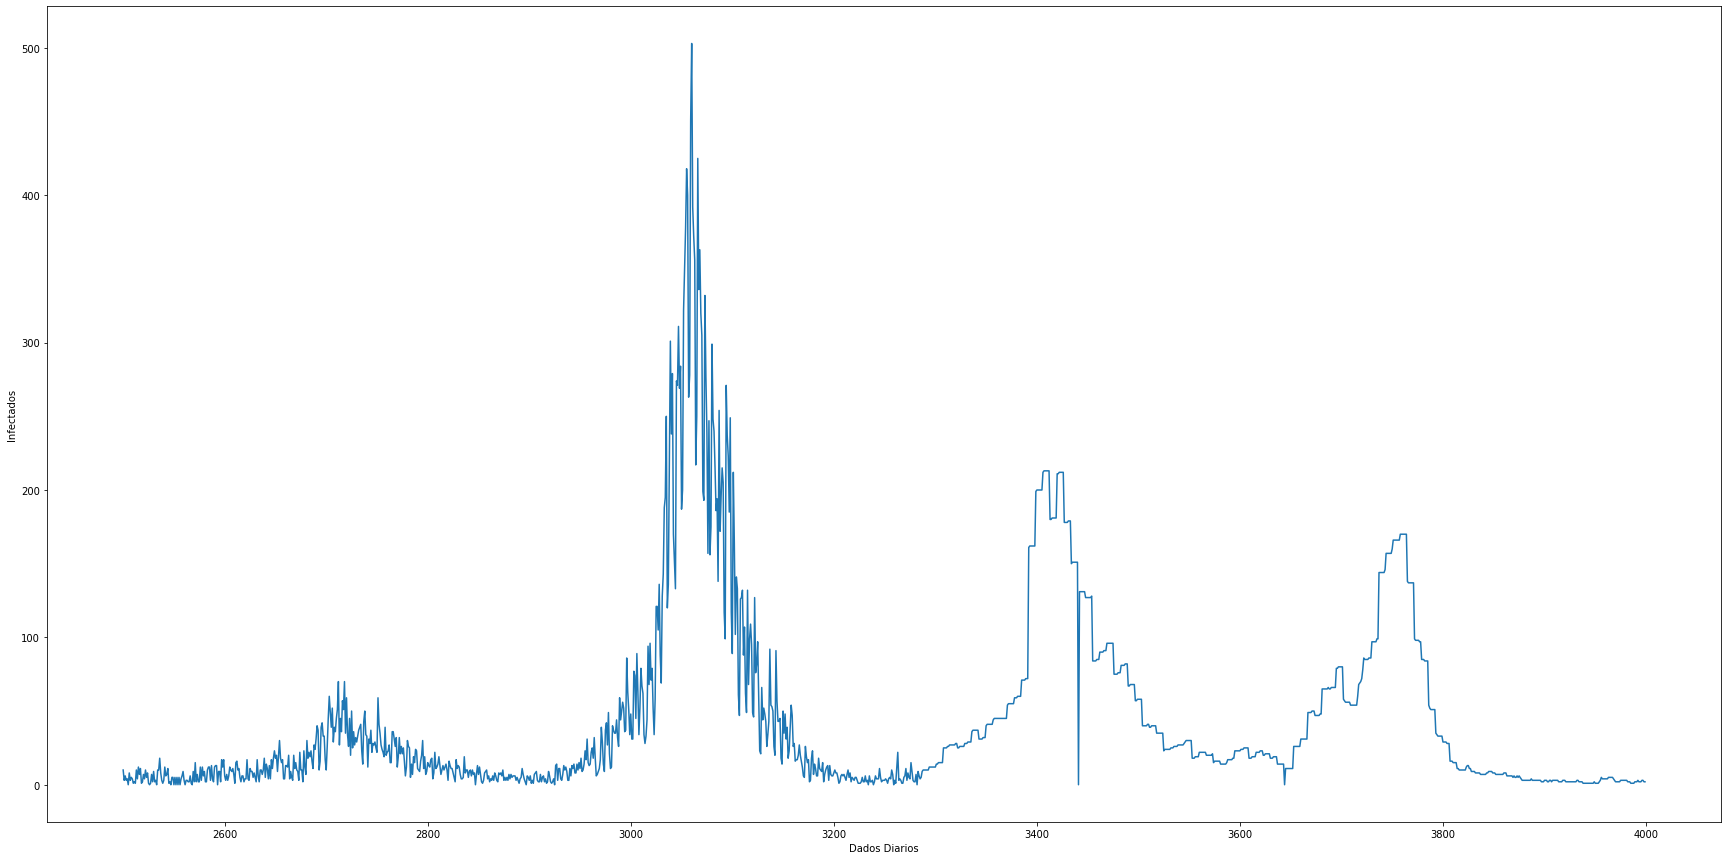

In [14]:
# Dados de "Infectados" de test
plt.figure(figsize=(30,15))
plt.xlabel('Dados Diarios')
plt.ylabel('Infectados')
plt.plot(submission['Infectados'])
plt.show()

In [15]:
print('Media e Variancia dos Infectados')
print('mean: ', y_train.mean()[2])
print('std :', y_train.std()[2])
print('var :', y_train.var()[2])

Media e Variancia dos Infectados
mean:  2009.9316
std : 1.9705011012013782
var : 3.882874589835844


Variancia maior que media sugere que a variável "Infectados" pode ser descrita por uma distribuição binomial negativa; portanto, usaremos uma regressão binomial negativa abaixo. 

Vamos analisar as Correlações


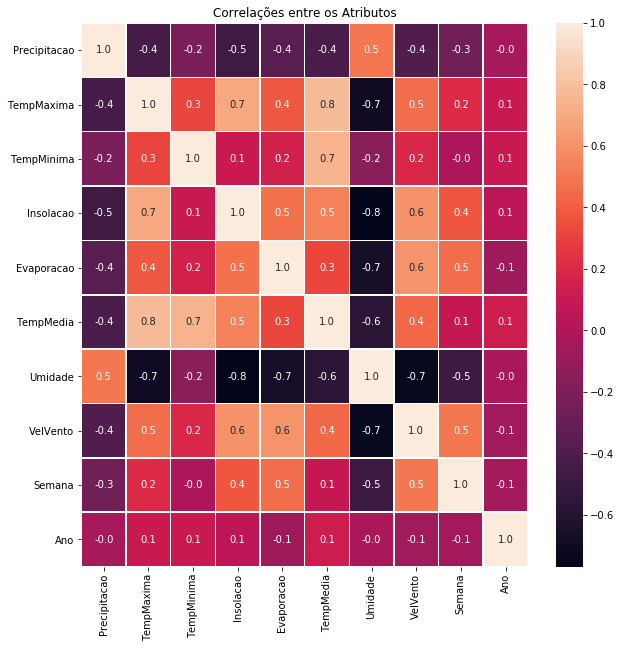

In [16]:
X_temp=X_train

del X_temp['Hora']
del X_temp['Estacao']
#del X_temp['Ano']
#del X_temp['Semana']

f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(X_temp.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
ax.set_title('Correlações entre os Atributos')
plt.show()


In [17]:
X_train,X_temp

(            Data  Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao  \
 0     01/01/2007     -0.358242   -0.614816    2.989972   0.138888    1.568422   
 1     02/01/2007     -0.358242    0.632565    2.737566   1.104726    1.356178   
 2     03/01/2007     -0.316350   -1.594901    1.727942  -2.114735    2.045971   
 3     04/01/2007      0.303642    0.008874    1.727942   1.072531   -0.660142   
 4     05/01/2007     -0.132028   -2.307691    0.129370  -1.567427    0.825567   
 ...          ...           ...         ...         ...        ...         ...   
 2495  31/10/2013     -0.358242    0.632565    1.391400   1.040336    0.931690   
 2496  01/11/2013     -0.358242    0.543466    1.223130   0.879363    1.303117   
 2497  02/11/2013     -0.349863    1.167157    1.223130   1.072531    0.666384   
 2498  03/11/2013     -0.316350    1.167157    0.886588  -0.440615    0.348018   
 2499  04/11/2013     -0.140406    0.454367    0.718317   0.203277    0.135774   
 
       TempMed

### Vamos verificar a correlação dos atributos com a variável dependente

Text(0.5, 1.0, 'Correlações dos Atributos com Infectados')

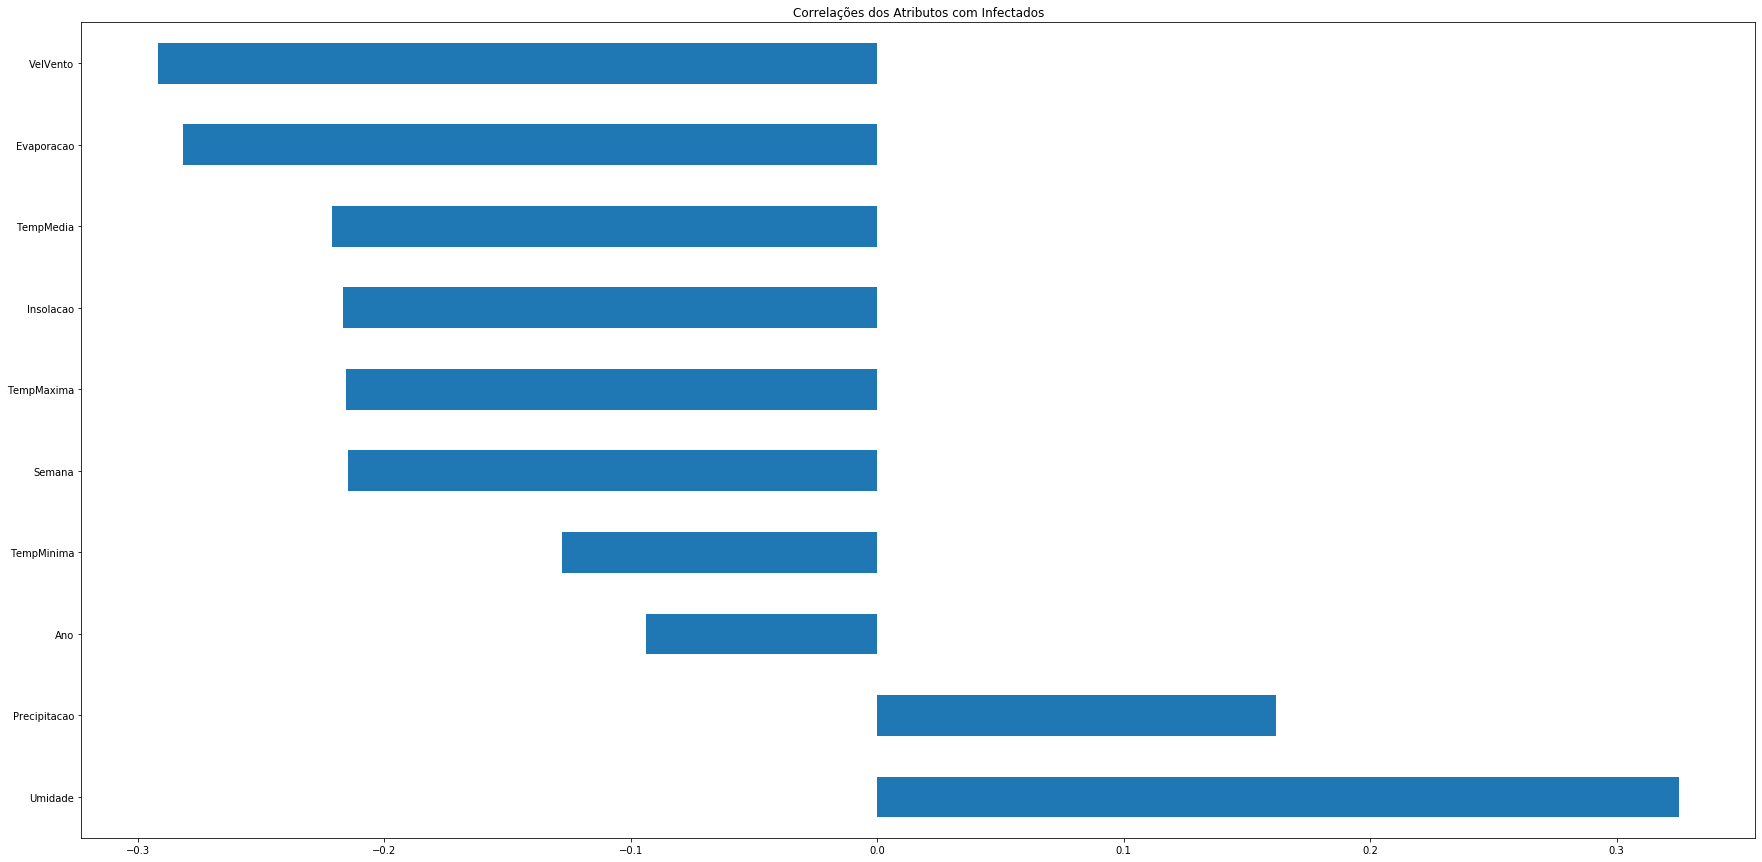

In [18]:
plt.figure(figsize=(30,15))
X_temp['Infectados']=y_train['Infectados']
correlations = X_temp.corr()
(correlations['Infectados'].drop('Infectados').sort_values(ascending=False).plot.barh())
plt.title('Correlações dos Atributos com Infectados')

### Vamos plotar o número de infectados para cada ano

Text(0, 0.5, 'Total de Infectados')

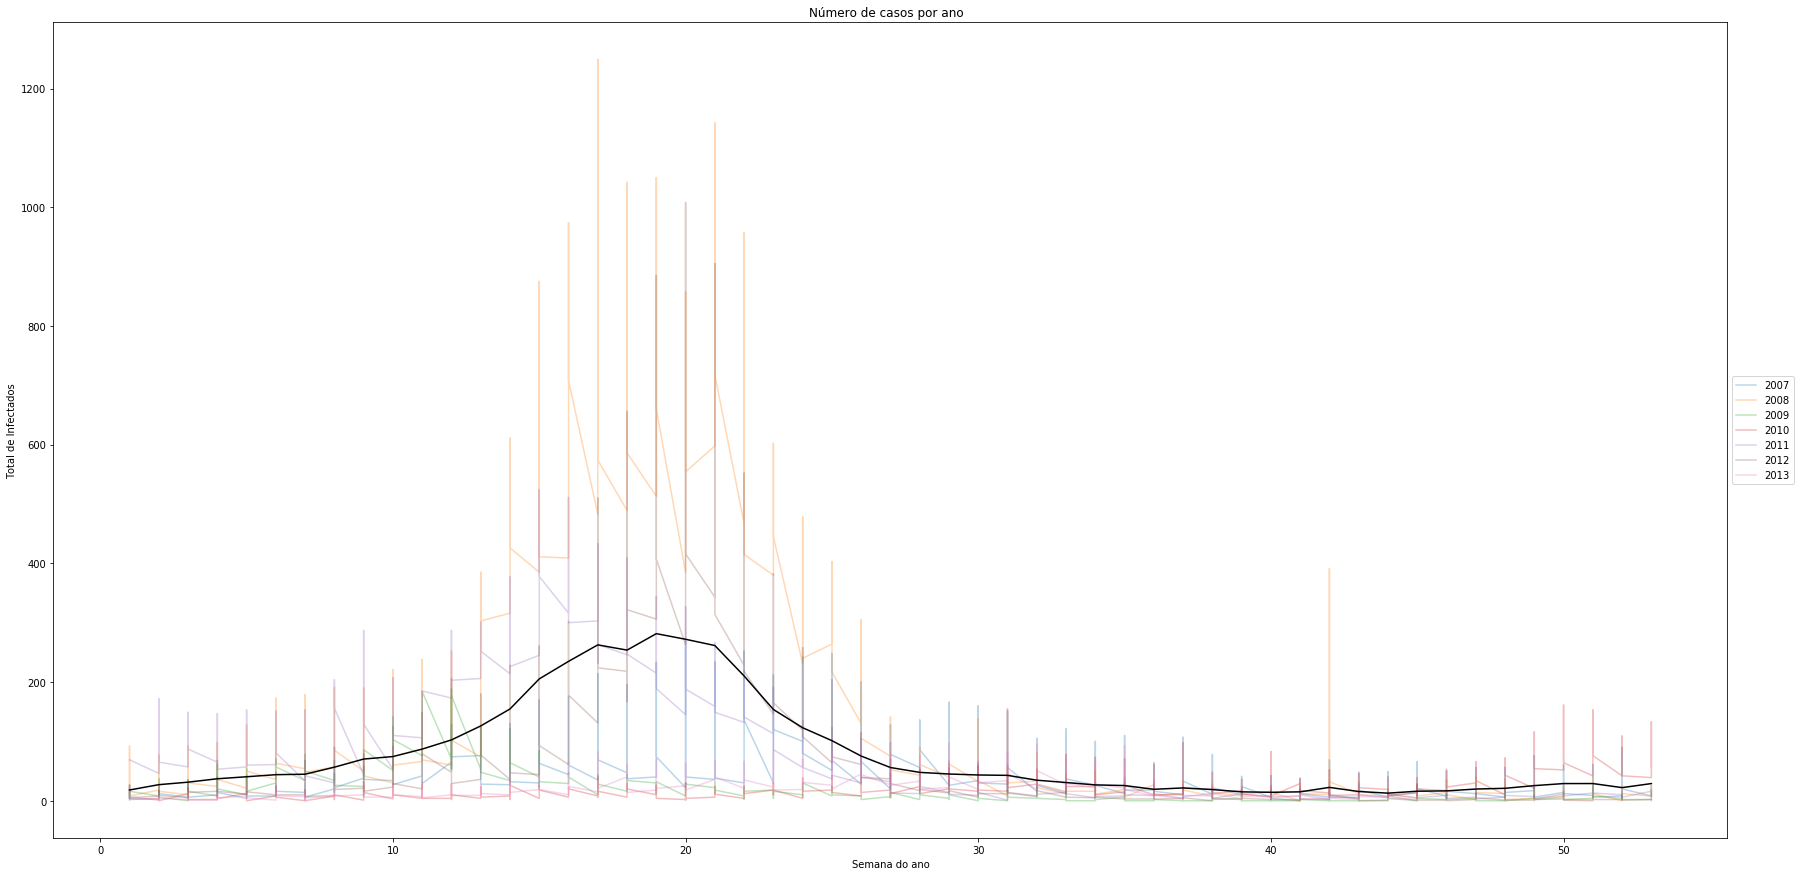

In [19]:
#Numero de Casos por dia
for i in set(y_train['Ano']):
    df = y_train[y_train['Ano'] == i]
    df.set_index('Semana', drop = True, inplace = True)
    plt.plot(df['Infectados'], alpha = .3)
    
y_train.groupby('Semana')['Infectados'].mean().plot(c = 'k', figsize = (30,15))
plt.legend(set(y_train['Ano']), loc='center left', bbox_to_anchor=(1, .5))

plt.title('Número de casos por ano  ')
plt.xlabel('Semana do ano')
plt.ylabel('Total de Infectados')

###  Verificas uma incidência maior de dengue no final do primeiro semestre, que coincide com o final do período chuvoso no Ceará

## Construindo modelos de Machine Learning


In [20]:
X_train

,Data,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao,TempMedia,Umidade,VelVento,Semana,Ano,Infectados
0,01/01/2007,-0.358242,-0.614816,2.989972,0.138888,1.568422,1.018314,-0.484999,1.076278,-1.715459,-1.488041,6
1,02/01/2007,-0.358242,0.632565,2.737566,1.104726,1.356178,1.924040,-1.179865,1.071033,-1.715459,-1.488041,10
2,03/01/2007,-0.316350,-1.594901,1.727942,-2.114735,2.045971,0.178860,0.711715,-0.483528,-1.715459,-1.488041,26
3,04/01/2007,0.303642,0.008874,1.727942,1.072531,-0.660142,0.797405,-0.871036,0.259958,-1.715459,-1.488041,20
4,05/01/2007,-0.132028,-2.307691,0.129370,-1.567427,0.825567,-0.616412,1.020544,0.868264,-1.715459,-1.488041,22
...,...,...,...,...,...,...,...,...,...,...,...,...
2495,31/10/2013,-0.358242,0.632565,1.391400,1.040336,0.931690,1.040404,-1.643109,1.104828,1.177094,1.557479,15
2496,01/11/2013,-0.358242,0.543466,1.223130,0.879363,1.303117,0.974132,-1.102658,0.699290,1.177094,1.557479,4
2497,02/11/2013,-0.349863,1.167157,1.223130,1.072531,0.666384,1.261313,0.016849,1.037238,1.177094,1.557479,4
2498,03/11/2013,-0.316350,1.167157,0.886588,-0.440615,0.348018,0.952041,-0.214773,0.834469,1.244363,1.557479,2


In [21]:
features=['Precipitacao','Insolacao','Evaporacao','Umidade','VelVento','TempMedia'] 

X_train=X_train.join(X_train.groupby(['Semana'])['Infectados'].mean(), on=['Semana'], rsuffix='_avg')
X_test=X_test.join(X_train.groupby(['Semana'])['Infectados'].mean(), on=['Semana'], rsuffix='_avg')

#TRAIN
X= X_train[features]
Y = X_train['Infectados']

#TEST
Xt= X_test[features]
X.fillna(method='bfill', inplace=True)
Xt.fillna(method='bfill', inplace=True)


## Criando os modelos e treinando 

### SVR - Support vetor Regression, um sub-tipo do SVM

In [22]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
t0 = time.time()
svr.fit(X,Y)

svr_fit = time.time() - t0
print("Complexidade SVR e largura de banda selecionadas e modelo ajustado em %.3f s"
      % svr_fit)
model=svr.best_estimator_
print(model)


Complexidade SVR e largura de banda selecionadas e modelo ajustado em 38.343 s
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


###   KNN (k-nearest neighbors )

In [23]:
knn = KNeighborsClassifier(n_neighbors = 30)
knn.fit(X,Y)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='uniform')

### Separa dados de TREINO (70%)  e teste (30%) Para VALIDAÇÃO

In [24]:
train_subtrain = X_train.sample(frac=0.7)
train_subtest = X_train.loc[~X_train.index.isin(train_subtrain.index)]

train_subtrain.fillna(method='bfill', inplace=True)
train_subtest.fillna(method='bfill', inplace=True)

#X_train.describe()
train_subtest.describe()


,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao,TempMedia,Umidade,VelVento,Semana,Ano,Infectados,Infectados_avg
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,0.020389,-0.011440,-0.032854,-0.040114,0.047738,-0.010656,-0.004824,0.044446,0.018459,0.013739,73.794667,77.187032
std,1.064575,1.027190,0.992050,1.046638,1.048222,1.008042,1.018103,1.009943,1.003529,1.005251,137.267130,80.204214
min,-0.358242,-5.604341,-3.320180,-2.533265,-2.198912,-4.305589,-2.955634,-2.578804,-1.715459,-1.488041,0.000000,12.795918
25%,-0.358242,-0.436619,-0.711984,-0.601588,-0.660142,-0.610889,-0.716621,-0.720091,-0.840966,-0.980454,11.000000,22.095238
50%,-0.358242,0.097973,-0.123036,0.460834,-0.053846,0.024224,-0.156868,0.090984,0.033527,0.034719,26.000000,40.408163
75%,-0.173920,0.632565,0.718317,0.718390,0.666384,0.681428,0.595904,0.733085,0.840751,1.049892,66.000000,101.244898
max,8.237869,2.414538,2.737566,1.136920,4.964329,2.630948,3.066539,2.862156,1.782512,1.557479,1144.000000,281.530612


### Treina e Valida os Modelos

In [25]:
#SVM
preds= model.predict(train_subtest[features]).astype(int)
train_subtest['fitted'] = preds

# KNN
preds2 = knn.predict(train_subtest[features]).astype(int)
train_subtest['fitted2'] = preds2



## Plota o Treino e Validação dos Modelos

Text(0, 0.5, 'Total de Infectados')

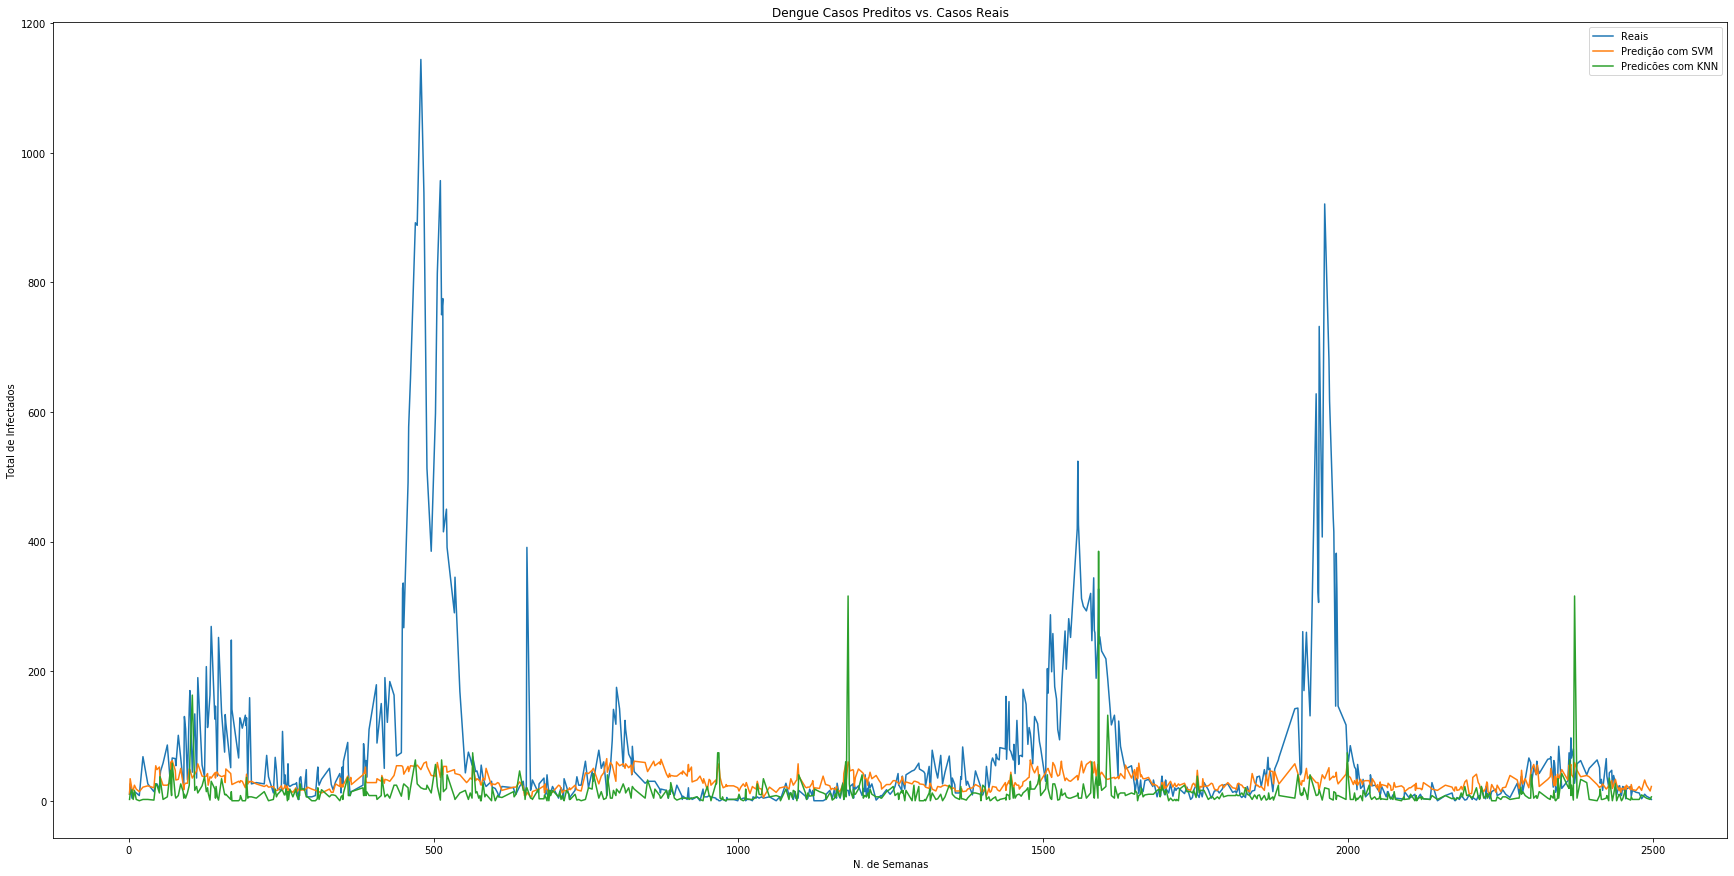

In [26]:
plt.figure(figsize=(30,15))
train_subtest.Infectados.plot(label="Reais")
train_subtest.fitted.plot( label="Predição com SVM")
train_subtest.fitted2.plot( label="Predicões com KNN")

plt.title("Dengue Casos Preditos vs. Casos Reais")
plt.legend()
plt.xlabel('N. de Semanas')
plt.ylabel('Total de Infectados')

## Calcula as métricas  - Cross validation com o score R2

### Scores para SVR

In [27]:
scores = cross_val_score(svr, X,Y, cv=5, scoring = "r2")
print("Scores usando SVR:", scores)
print("Média  usando SVR:", scores.mean())

Scores usando SVR: [-0.28330171 -0.01125738 -0.01368266 -0.33206854 -0.07116629]
Média  usando SVR: -0.14229531753025432


### Scores para KNN

In [28]:
scores = cross_val_score(knn, X,Y, cv=5, scoring = "r2")
print("Scores usando KNN:", scores)
print("Média  usando KNN:", scores.mean())

Scores usando KNN: [-0.2044122  -0.18851923 -0.19259507 -0.18030115 -0.19303459]
Média  usando KNN: -0.19177244654631442


## Predição com dados de TESTE 

### Predição KNN e SVM

In [29]:
#SVM

data['Infectados']=data2['Infectados']
newPreds= model.predict(data[features]).astype(int)
data['fitted'] = newPreds

# KNN
newPreds2 = knn.predict(data[features]).astype(int)
data['fitted2'] = newPreds2


Text(0, 0.5, 'Total de Infectados')

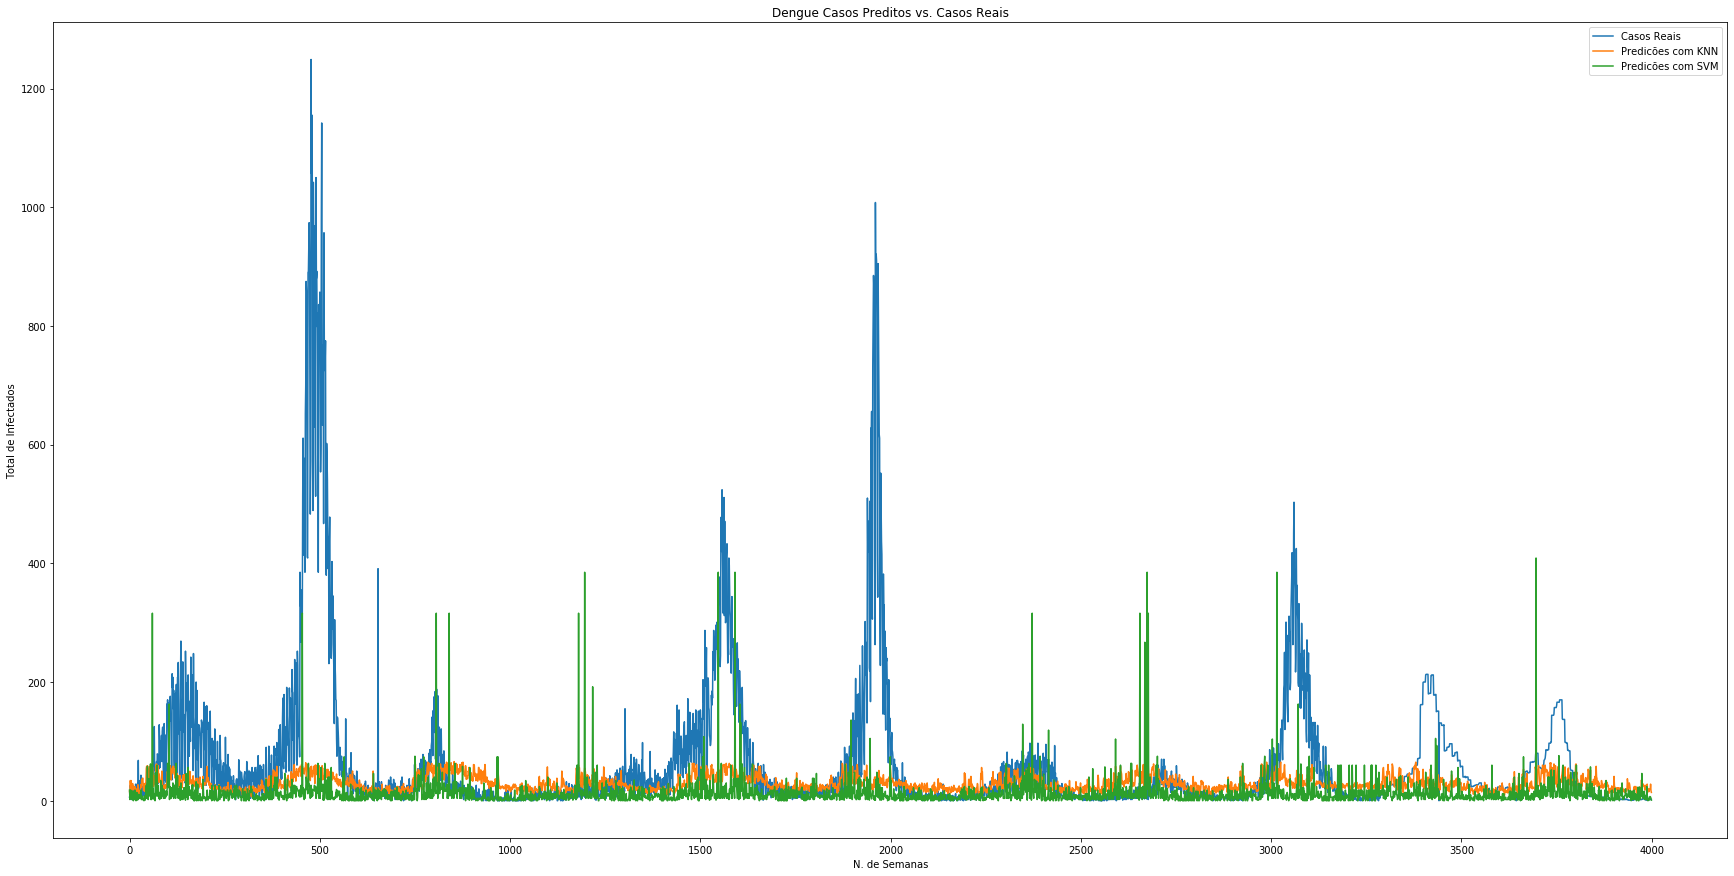

In [30]:

plt.figure(figsize=(30,15))
data2['Infectados'].plot( label="Casos Reais")
data['fitted'].plot(label="Predicões com KNN")
data['fitted2'].plot(label="Predicões com SVM")

plt.title("Dengue Casos Preditos vs. Casos Reais")
plt.legend()
plt.xlabel('N. de Semanas')
plt.ylabel('Total de Infectados')

## Conclusão
### Podemos afirmar que os modelos baseados em SVM KNN funcionam bem para previsão de casos dengue em Fortaleza, com uma precisão maior para o modelo baseado no KNN